In [1]:
library("igraph")
library("ggtree")
library("phangorn")
library("treeio")
library("Biostrings")
library("msa")
library("ape")
library("insect")

Warning message:
"package 'igraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'ggtree' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 
ggtree v2.0.2  For help: https://yulab-smu.github.io/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

- Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution 2018, 35(12):3041-3043. doi: 10.1093/molbev/msy194
- Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R pac

Построем филогенетическое дерево по геномам различных штаммов коронавируса. Данные загружены с сайта [NCBI](https://www.ncbi.nlm.nih.gov/genbank/sars-cov-2-seqs/#nucleotide-sequences) и собраны в один файл `common.fasta` в формате `fasta`. Длины ДНК-последовательностей отличаются, поэтому предварительно требуется выровнять их. Это можно сделать с помощью следующего кода:

In [ ]:
fasta_data <- read.fasta("common.fasta")
l = c(dna2char(fasta_data[1]))
for (i in 2:16) {
    l = rbind(l, c(dna2char(fasta_data[i])))
}
string.set <- DNAStringSet(l)
string.set <- msa(DNAStringSet(l))
fasta_data <- as.DNAbin(string.set)

Демонстрация работы на маленьких данных:

In [2]:
Q1 <- as.DNAbin(c("T","C","C","G","A","A","T","A","A","G","T","A","A","A"))
Q2 <- as.DNAbin(c("C","C","G","A","A","T","C","A","G","T","A"))
Q3 <- as.DNAbin(c("T","C","T","A","A","A","T","A","A","G","C","A","C"))
print(msa(DNAStringSet(c(dna2char(Q1),dna2char(Q2),dna2char(Q3)))))

use default substitution matrix
CLUSTAL 2.1  

Call:
   msa(DNAStringSet(c(dna2char(Q1), dna2char(Q2), dna2char(Q3))))

MsaDNAMultipleAlignment with 3 rows and 14 columns
    aln 
[1] TCCGAATAAGTAAA
[2] -CCGAATCAGTA--
[3] TCTAAATAAGCAC-
Con TCCGAATAAGTA?- 


Однако для выравнивания нескольких десятков последовательностей длины порядка $30000$ нуклеотидов у меня не достаточно вычислительной мощности (это займет слишком много времени), поэтому для получения того же результата воспользуемся онлайн-ресурсом [Clustal Omega](https://www.ebi.ac.uk/Tools/msa/clustalo/). Полученный в результате файл с выровненными ДНК-последовательностями назовем `common_msa.fasta`.

Теперь построем филогенетического дерева. Для удобства в подписи вершин вынесем только **id** штамма, страну и дату обнаружения.

In [3]:
rnames <- c("MT007544 25/01/20 AU",
            "MT039890 01/20 KR",
            "MN988713 21/01/20 USA IL",
            "MT291832 25/01/20 CN BJ",
            "MN985325 19/01/20 USA WA",
            "MN938384 10/01/20 CN SZ",
            "MN997409 22/01/20 USA AZ",
            "MT291830 30/12/19 CN WHN",
            "LC529905 01/20 JP",
            "MT019529 23/12/19 CN WHN",
            "MN994468 22/01/20 USA CA",
            "MT072688 13/01/20 NP",
            "MT039873 20/01/20 CN HNG",
            "LR757996 01/01/20 CN WHN",
            "MT192772 22/01/20 VN",
            "MT192759 25/01/20 TW")

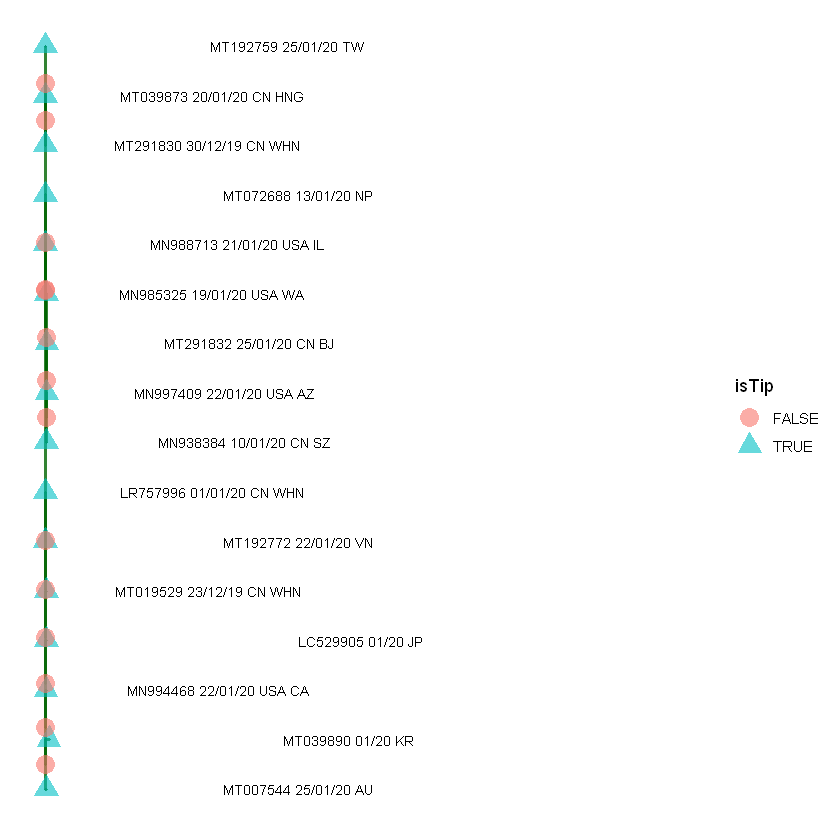

In [7]:
fasta_data <- as.matrix(read.fasta("common_msa.fasta"))
rownames(fasta_data) <- rnames
phy.data <- as.phyDat(as.matrix(fasta_data))
tree <- nj(dist.ml(phy.data))
ggtree(tree, lwd = 1, color = "darkgreen", alpha = 0.8, right = TRUE) +
  geom_tiplab(size = 3, angle = 0, offset = 0.05, hjust = 3) +
  geom_point(aes(shape = isTip, color = isTip), size = 5, alpha = 0.6)

Реализуем функцию, позволяюшую сравнивать поэлементно нуклеотидные последовательности одной длины и возвращающую сходство в виде числа от $0$ до $1$.

In [5]:
element_wise.compare <- function(seq1,seq2){
    mean(strsplit(as.character(seq1),"")[[1]] == 
       strsplit(as.character(seq2),"")[[1]])
}

In [50]:
element_wise.compare(DNAseq1, DNAseq2)

[1] 0.9993312

Рассмотрим популярную теорию заговора о том, что коронавирус `SARS-CoV-2` создан искусственно, и постараемся ее опровергнуть.

**Гипотеза** $H_0$ `SARS-CoV-2` - это вирус, созданный искусственно и затем мутировавший.

**Гипотеза** $H_{0.1}$ `SARS-CoV-2` - это сбежавший (или выпущенный) из лаборатории Института вирусологии Уханя вирус `SHC014-MA15`, который был там создан путем замены гена, кодирующего шиповидный белок вируса `SARS Coronavirus MA15`, на аналогичный ген из `RsSHC014-COV`.

Для начала воспроизведем [исследование, описанное Александром Панчиным](https://vk.com/scinquisitor?w=wall187756_253565).

### Воспроизведение исследования А. Панчина.

В данной части исследования рассматриваются вирусы: `SARS Coronavirus MA15` (штамм JF292920), `RaTG13` (эти два взяты у летучих мышей в 2014 и 2013 годах соответственно), `RsSHC014-COV` и современный `COVID-19` (я рассмотрел штамм `MT019529`, один из самых ранних найденных в Ухани в декабре 2019 г.)

У них будем сравнивать шиповидный белок и полипротеин `1ab` (у некоторых вирусов он называется `1ab`, у других - `orf1ab`, но это разновидности одного и того же протеина. С шиповидном белком то же самое: есть названия `spike protein`, `surface glycoprotein`, `spike_glycoprotein_precursor`).

У искусственно созданного `SHC014-MA15`, согласно статье 2015 года, с вирусом `RsSHC014-COV` совпадает шиповидный белок, а с вирусом `SARS Coronavirus MA15` - полипротеин `1ab` (и, видимо, весь геном кроме шиповидного белка).

#### 1.

В исследовании говорится:

"Из всех известных вирусов наиболее родственный по этому полипротеину коронавирус из летучий мыши – `RaTG13` ($98.53\% $ сходства). Полипротеин `1ab` из коронавируса `MA15` имеет лишь $86.03\%$ сходства". Сравним эти полипротеины самостоятельно.

In [79]:
COVID_19.1ab <- read.fasta("MT019529_polyprotein_orf1ab.fasta")
RaTG13.1ab <- read.fasta("RaTG13_polyprotein_orf1ab.fasta")
MA15.1ab <- read.fasta("MA15_polyprotein_orf1ab.fasta")
RsSHC014.1ab <- read.fasta("RsSHC014_1ab.fasta")

In [80]:
string.set <- AAStringSet(c(toupper(aa2char(COVID_19.1ab)),
                     toupper(aa2char(RaTG13.1ab)),
                     toupper(aa2char(MA15.1ab)),
                     toupper(aa2char(RsSHC014.1ab))))
string.set

  A AAStringSet instance of length 4
    width seq                                               names               
[1]  7096 MESLVPGFNEKTHVQLSLPVLQV...SKGRLIIRENNRVVISSDVLVNN QHU36823.1 orf1ab...
[2]  7095 MESLVPGFNEKTHVQLSLPVLQV...SKGRLIIRENNRVVISSDVLVNN QHR63299.1 orf1ab...
[3]  7073 MESLVLGVNEKTHVQLSLPVLQV...EKGRLIIRENNRVVVSSDILVNN AEA10982.1 polypr...
[4]  7073 MESLVLGVNEKTHVQLSLPVLQV...EKGRLIIRESNKVVVSSDILVNI AGZ48805.1 non-st...

Выравнивание:

In [81]:
string.set <- AAStringSet(msa(string.set))
string.set

use default substitution matrix


  A AAStringSet instance of length 4
    width seq                                               names               
[1]  7100 MESLVPGFNEKTHVQLSLPVLQV...SKGRLIIRENNRVVISSDVLVNN QHU36823.1 orf1ab...
[2]  7100 MESLVPGFNEKTHVQLSLPVLQV...SKGRLIIRENNRVVISSDVLVNN QHR63299.1 orf1ab...
[3]  7100 MESLVLGVNEKTHVQLSLPVLQV...EKGRLIIRENNRVVVSSDILVNN AEA10982.1 polypr...
[4]  7100 MESLVLGVNEKTHVQLSLPVLQV...EKGRLIIRESNKVVVSSDILVNI AGZ48805.1 non-st...

In [82]:
"Сходство полипротеина 1ab для COVID-19 и RaTG13:"
element_wise.compare(string.set[1],string.set[2])
"Сходство полипротеина 1ab для COVID-19 и MA15:"
element_wise.compare(string.set[1],string.set[3])
"Сходство полипротеина 1ab для COVID-19 и RsSHC014:"
element_wise.compare(string.set[1],string.set[4])
"Сходство полипротеина 1ab для RaTG13 и MA15:"
element_wise.compare(string.set[2],string.set[3])
"Сходство полипротеина 1ab для MA15 и RsSHC014:"
element_wise.compare(string.set[2],string.set[4])
"Сходство полипротеина 1ab для MA15 и RsSHC014:"
element_wise.compare(string.set[3],string.set[4])

[1] "Сходство полипротеина 1ab для COVID-19 и RaTG13:"

[1] 0.9852113

[1] "Сходство полипротеина 1ab для COVID-19 и MA15:"

[1] 0.8604225

[1] "Сходство полипротеина 1ab для COVID-19 и RsSHC014:"

[1] 0.8605634

[1] "Сходство полипротеина 1ab для RaTG13 и MA15:"

[1] 0.8595775

[1] "Сходство полипротеина 1ab для MA15 и RsSHC014:"

[1] 0.8592958

[1] "Сходство полипротеина 1ab для MA15 и RsSHC014:"

[1] 0.984507

Сходство действительно такое, как заявлено в статье (числа отличаются в пределах $0.01\%$, но, видимо, я и А. Панчин просто рассмотрели разные штаммы `COVID-19`, которые многочисленны, но очень похожи между собой с точки зрения конкретных протеинов, в т.ч. `1ab`.)

Таким образом, ген, отвечающий протеину `1ab`, у вируса `SARS Coronavirus MA15` (а значит, и у созданного на его основе вируса `SHC014-MA15`) гораздо сильнее отличается от современного `COVID-19`, чем у `RsSHC014-COV`, взятого у летучих мышей не позднее 2014 года.

#### 2.

Теперь воспроизведем анализ для шиповидного белка.

"Шиповидный белок из RsSHC014 имеет лишь 77.31% сходства с таковым из SARS-CoV-2. Шиповидный белок из Coronavirus MA15 имеет 75.88% сходства."

"А вот наиболее родственный этому белку – его аналог из все того же коронавируса летучей мыши – RaTG13 (97.41% сходства)."

In [72]:
COVID_19.spike <- read.fasta("MT019529_surface_glycoprotein.fasta")
RaTG13.spike <- read.fasta("RaTG13_spike_glycoprotein.fasta")
MA15.spike <- read.fasta("MA15-COV_spike_glycoprotein_precursor.fasta")
RsSHC014.spike <- read.fasta("RsSHC014_spike_protein.fasta")

In [74]:
string.set <- AAStringSet(c(toupper(aa2char(COVID_19.spike)),
                     toupper(aa2char(RaTG13.spike)),
                     toupper(aa2char(MA15.spike)),
                     toupper(aa2char(RsSHC014.spike))))
string.set

  A AAStringSet instance of length 4
    width seq                                               names               
[1]  1273 MFVFLVLLPLVSSQCVNLTTRTQ...GSCCKFDEDDSEPVLKGVKLHYT QHU36824.1 surfac...
[2]  1269 MFVFLVLLPLVSSQCVNLTTRTQ...GSCCKFDEDDSEPVLKGVKLHYT QHR63300.2 spike ...
[3]  1255 MFIFLLFLTLTSGSDLDRCTTFD...GSCCKFDEDDSEPVLKGVKLHYT AEA10983.1 spike ...
[4]  1256 MKLLVLVFATLVSSYTIEKCLDF...GSCCKFDEDDSEPVLKGVKLHYT AGZ48806.1 spike ...

In [75]:
string.set <- AAStringSet(msa(string.set))
string.set

use default substitution matrix


  A AAStringSet instance of length 4
    width seq                                               names               
[1]  1278 -MFIFLLFLTLTSGSDLDRCTTF...GSCCKFDEDDSEPVLKGVKLHYT AEA10983.1 spike ...
[2]  1278 MKLLVLVFATLVSSYTIEKCLDF...GSCCKFDEDDSEPVLKGVKLHYT AGZ48806.1 spike ...
[3]  1278 -MFVFLVLLPLVSS----QCVNL...GSCCKFDEDDSEPVLKGVKLHYT QHU36824.1 surfac...
[4]  1278 -MFVFLVLLPLVSS----QCVNL...GSCCKFDEDDSEPVLKGVKLHYT QHR63300.2 spike ...

In [77]:
"Сходство шиповидного белка для COVID-19 и RaTG13:"
element_wise.compare(string.set[1],string.set[2])
"Сходство шиповидного белка для COVID-19 и MA15:"
element_wise.compare(string.set[1],string.set[3])
"Сходство шиповидного белка для COVID-19 и RsSHC014:"
element_wise.compare(string.set[1],string.set[4])
"Сходство шиповидного белка для RaTG13 и MA15:"
element_wise.compare(string.set[2],string.set[3])
"Сходство шиповидного белка для MA15 и RsSHC014:"
element_wise.compare(string.set[2],string.set[4])
"Сходство шиповидного белка для MA15 и RsSHC014:"
element_wise.compare(string.set[3],string.set[4])

[1] "Сходство шиповидного белка для COVID-19 и RaTG13:"

[1] 0.900626

[1] "Сходство шиповидного белка для COVID-19 и MA15:"

[1] 0.756651

[1] "Сходство шиповидного белка для COVID-19 и RsSHC014:"

[1] 0.7644757

[1] "Сходство шиповидного белка для RaTG13 и MA15:"

[1] 0.7668232

[1] "Сходство шиповидного белка для MA15 и RsSHC014:"

[1] 0.7707355

[1] "Сходство шиповидного белка для MA15 и RsSHC014:"

[1] 0.9741784

Вывод: расчеты А. Панчина подтвердились, сходство шиповидного белка вирусов `MA15` и `RsSHC014` (следовательно, и `SHC014-MA15`) с современным коронавирусом ($75.66\%$, $76.44\%$ соответственно в данном эксперименте) почти такое же, как он пишет ($75.88\%$, $77.31\%$), разница связана с выбором конкретных штаммов. Сходство `MA15` и `RsSHC014` в данном эксперименте ($97.41\%$) и у А. Панчина ($97.41\%$) также совпало, даже с точностью до сотых процента.

### Мое добавление к исследованию.

Сравним не просто белки, а полные геномы рассмотренных вирусов (теперь в формате ДНК):

In [84]:
COVID_19 <- read.fasta("MT019529_2019_12_23_China_Wuhan.fasta")
RaTG13 <- read.fasta("RaTG13.fasta")
MA15 <- read.fasta("MA15-COV.fasta")
RsSHC014 <- read.fasta("RsSHC014.fasta")

In [95]:
string.set <- AAStringSet(c(toupper(dna2char(COVID_19)),
                     toupper(dna2char(RaTG13)),
                     toupper(dna2char(MA15)),
                     toupper(dna2char(RsSHC014))))
string.set

  A AAStringSet instance of length 4
    width seq                                               names               
[1] 29899 ATTAAAGGTTTATACCTTCCCAG...AAAAAAAAAAAAAAAAAAAAAAA MT019529.1 Severe...
[2] 29855 CTTTCCAGGTAACAAACCAACGA...GACAAAAAAAAAAAAAAAAAAAA MN996532.1 Bat co...
[3] 29646 CGATCTCTTGTAGATCTGTTCTC...TGTGTAAAATTAATTTTAGTAGT JF292920.1 SARS c...
[4] 29787 ATATTAGGTTTTTACCTACCCAG...ATGACAAAAAAAAAAAAAAAAAA KC881005.1 Bat SA...

In [96]:
string.set <- AAStringSet(msa(string.set))
string.set

use default substitution matrix


  A AAStringSet instance of length 4
    width seq                                               names               
[1] 29959 ATTAAAGGTTTATACCTTCCCAG...AAAAAAAAAAAAAAAAAAAAAAA MT019529.1 Severe...
[2] 29959 ---------------CTTTCCAG...AAAAAAAAAAAAAA--------- MN996532.1 Bat co...
[3] 29959 -----------------------...----------------------- JF292920.1 SARS c...
[4] 29959 ATATTAGGTTTTTACCTACCCAG...AAAAAAAAAAAA----------- KC881005.1 Bat SA...

In [97]:
"Сходство геномов COVID-19 и RaTG13:"
element_wise.compare(string.set[1],string.set[2])
"Сходство геномов COVID-19 и MA15:"
element_wise.compare(string.set[1],string.set[3])
"Сходство геномов COVID-19 и RsSHC014:"
element_wise.compare(string.set[1],string.set[4])
"Сходство геномов RaTG13 и MA15:"
element_wise.compare(string.set[2],string.set[3])
"Сходство геномов MA15 и RsSHC014:"
element_wise.compare(string.set[2],string.set[4])
"Сходство геномов MA15 и RsSHC014:"
element_wise.compare(string.set[3],string.set[4])

[1] "Сходство геномов COVID-19 и RaTG13:"

[1] 0.9603124

[1] "Сходство геномов COVID-19 и MA15:"

[1] 0.7851397

[1] "Сходство геномов COVID-19 и RsSHC014:"

[1] 0.7899796

[1] "Сходство геномов RaTG13 и MA15:"

[1] 0.7847391

[1] "Сходство геномов MA15 и RsSHC014:"

[1] 0.7891785

[1] "Сходство геномов MA15 и RsSHC014:"

[1] 0.9481291

`COVID-19` отличается от `MA15`, и от `RsSHC014` гораздо сильнее, чем от `RaTG13`.

Теперь построим филогенетическое дерево по $55$ штаммам, включающим в себя $1$ штамм `RaTG13`, $1$ штамм `RsSHC014`, $4$ штамма `MA15` и $49$ штаммов `COVID-19`. Данные, как и выше, были заранее выровнены с помощью онлайн ресурса.

Для удобства визуализации дерева вершины будем помечать численными индексами и отдельно выпишем их расшифровку.

55 DNA sequences in binary format stored in a matrix.

All sequences of same length: 29970 

Labels:
MN996532.1 Bat coronavirus RaTG13, complete genome
MT233522.1 Severe acute respiratory syndrome coronavirus 2 i...
MT007544.1 Severe acute respiratory syndrome coronavirus 2 i...
MT308704.1 Severe acute respiratory syndrome coronavirus 2 i...
MT258383.1 Severe acute respiratory syndrome coronavirus 2 i...
MT039890.1 Severe acute respiratory syndrome coronavirus 2 i...
...

Base composition:
    a     c     g     t 
0.298 0.185 0.197 0.320 
(Total: 1.65 Mb)

[[1]]
[1] "MN996532.1 Bat coronavirus RaTG13, complete genome"

[[2]]
[1] "MT233522.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/ESP/Valencia7/2020, complete genome"

[[3]]
[1] "MT007544.1 Severe acute respiratory syndrome coronavirus 2 isolate Australia/VIC01/2020, complete genome"

[[4]]
[1] "MT308704.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/UNC_200189/2020, complete genome"

[[5]]
[1] "MT258383.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/CZB-RR057-015/2020, complete genome"

[[6]]
[1] "MT039890.1 Severe acute respiratory syndrome coronavirus 2 isolate SNU01, complete genome"

[[7]]
[1] "MT293212.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USAWA-UW449/2020, complete genome"

[[8]]
[1] "MT281577.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Fuyang_FY002/2020, complete genome"

[[9]]
[1] "MT019529.1 Severe acute respiratory syndrome coronavirus 2 isolate BetaCoV/Wuhan/IPBCAMS-WH-01/2019, complete genome"

[[10]]
[1] "LC529905.1 Severe acute respiratory syndrome coronavirus 2 TKYE6182_2020 RNA, complete genome"

[[11]]
[1] "MT291828.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Wuhan_IME-WH03/2019, complete genome"

[[12]]
[1] "MT019531.1 Severe acute respiratory syndrome coronavirus 2 isolate BetaCoV/Wuhan/IPBCAMS-WH-03/2019, complete genome"

[[13]]
[1] "MT291830.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Wuhan_IME-WH05/2019, complete genome"

[[14]]
[1] "MN908947.3 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome"

[[15]]
[1] "MT263436.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW356/2020, complete genome"

[[16]]
[1] "MT262993.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-Cov-2/human/PAK/Manga1/2020, complete genome"

[[17]]
[1] "MT012098.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/IND/29/2020, complete genome"

[[18]]
[1] "MT276598.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/ISR/ISR_IT0320/2020, complete genome"

[[19]]
[1] "MT263074.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/PER/Peru-10/2020, complete genome"

[[20]]
[1] "MT263439.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW359/2020, complete genome"

[[21]]
[1] "MT292570.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/ESP/Valencia17/2020, complete genome"

[[22]]
[1] "MT233519.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/ESP/Valencia5/2020, complete genome"

[[23]]
[1] "MN988713.1 Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV/USA-IL1/2020, complete genome"

[[24]]
[1] "MT246452.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW195/2020, complete genome"

[[25]]
[1] "MT246464.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW207/2020, complete genome"

[[26]]
[1] "MT259254.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/WA-UW262/2020, complete genome"

[[27]]
[1] "MT304485.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/NH_0008/2020, complete genome"

[[28]]
[1] "MT276323.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/RI_0520/2020, complete genome"

[[29]]
[1] "MT049951.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Yunnan-01/2020, complete genome"

[[30]]
[1] "MT291832.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Wuhan_IME-BJ02/2020, complete genome"

[[31]]
[1] "MN985325.1 Severe acute respiratory syndrome coronavirus 2 isolate 2019-nCoV/USA-WA1/2020, complete genome"

[[32]]
[1] "MN938384.1 Severe acute respiratory sy

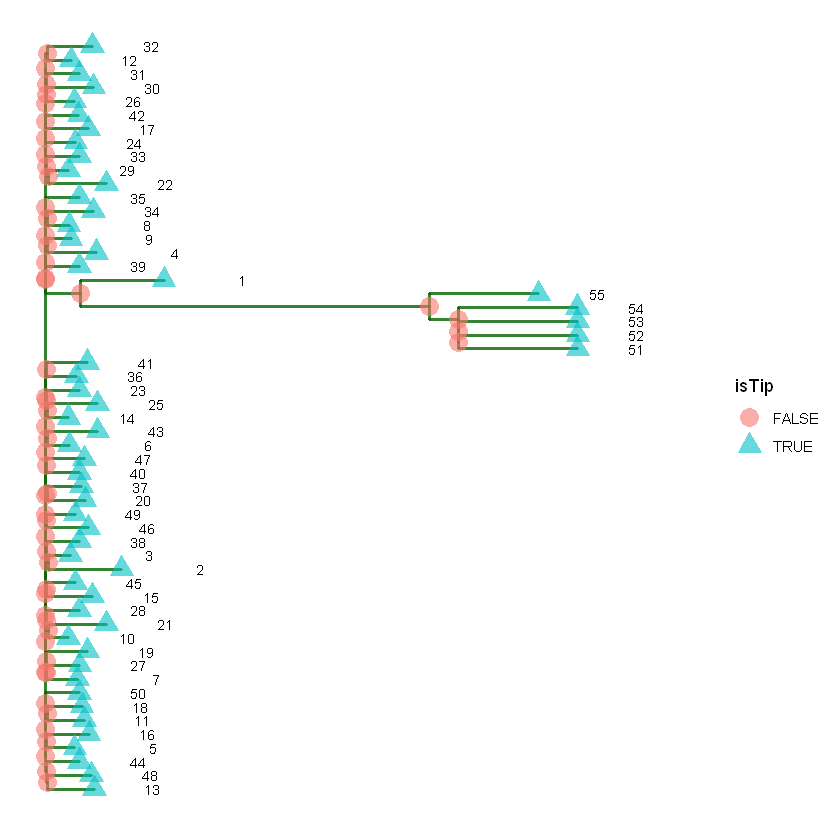

In [10]:
fasta_data <- as.matrix(read.fasta("common_msa_2.fasta"))
fasta_data
as.list(labels(fasta_data))
rownames(fasta_data) <- 1:55
phy.data <- as.phyDat(as.matrix(fasta_data))
tree <- nj(dist.logDet(phy.data))
ggtree(tree, lwd = 1, color = "darkgreen", alpha = 0.8, right = TRUE) +
  geom_tiplab(size = 3, angle = 0, offset = 0.05, hjust = 3) +
  geom_point(aes(shape = isTip, color = isTip), size = 5, alpha = 0.6)

Снова видим, что `RaTG13` (индекс $1$ ) гораздо ближе к штаммам `COVID-19`, чем `MA15` (индексы $51-54$ ) и `RsSHC014`(индекс $55$ ), а также то, что штаммы `COVID-19` похожи между собой и сильно ветвятся. Полученное дерево вряд ли хорошо показывает генеалогическое происхождение видов, но зато отображает степень их сходства. Также можно, например заметить, что из рассмотренных штаммов `COVID-19` сильнее всех отличаются от других $2$, $21$, $22$, которые были найдены в Валенсии, т.е. в Испании вирус в своем развитии уходит от других видов.

**Подведем итог:**

1. Из рассмотренных геномов `COVID-19` наиболее похож на `RaTG13`. Он сильно отличается и от `MA15`, и от `RsSHC014`, и от искусственно созданного их "гибрида" - `SHC014-MA15`.

2. Поэтому `COVID-19`, скорее всего, мутировал из вирусов летучих мышей, встречающихся в естесственных условиях (вероятно, из `RaTG13` или его родственника). У него было много времени для этого (более 5 лет), поэтому гипотеза о его лабораторном происхождении (необязательно от `SHC014-MA15`) с достаточно большой степенью уверенности отвергается.